In [13]:
import numpy as np
from environments.data_separator import dataSrlLoad, plotDistribution, PCA
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from multiprocessing import Pool
import os
import multiprocessing
from state_representation.models import loadSRLModel, getSRLDim
from srl_zoo.utils import loadData
from srl_zoo.preprocessing.data_loader import SupervisedDataLoader, DataLoader

In [14]:
BATCH_SIZE = 256
N_WORKERS = 8
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")
VALIDATION_SIZE = 0.2  # 20% of training data for validation

In [15]:
srl_model_path = 'srl_zoo/logs/Omnibot_random_escape/19-06-17_17h36_08_custom_cnn_ST_DIM200_inverse_autoencoder/srl_model.pth'
data_folder = '/home/tete/Robotics-branches/escape-dev/robotics-rl-srl/data/escape_on_policy/'

In [23]:
def dataSrlLoad(data_folder, srl_model_path, state_dim=2, pca_mode=True, normalized=True):
    """

    :param data_folder: (str) the path to the dataset we want to sample
    :param srl_model_path: (str)
    :return: the dataset after the srl evaluation and a pca preprocessd,
             it self, a random sampled training set, validation set
    """
    state_dim = getSRLDim(srl_model_path)
    srl_model = loadSRLModel(srl_model_path, th.cuda.is_available(), state_dim, env_object=None)
    # load images and other data
    training_data, ground_truth, true_states,_ = loadData(data_folder, absolute_path=True)
    images_path = ground_truth['images_path']
    import ipdb
    ipdb.set_trace()
    ground_truth_states_dim = true_states.shape[1]

    # we change the path to the local path at the toolbox level
    images_path_copy = ["srl_zoo/data/" + images_path[k] for k in range(images_path.shape[0])]
    images_path = np.array(images_path_copy)

    num_samples = images_path.shape[0]  # number of samples

    # indices for all time steps where the episode continues
    #indices = np.array([i for i in range(num_samples-1) if not episode_starts[i + 1]], dtype='int64')
    indices = np.arange(num_samples)

    minibatchlist = [np.array(sorted(indices[start_idx:start_idx + BATCH_SIZE]))
                     for start_idx in range(0, len(indices) - BATCH_SIZE + 1, BATCH_SIZE)]

    data_loader = DataLoader(minibatchlist, images_path, n_workers=N_WORKERS, multi_view=False,
                             use_triplets=False, is_training=True, absolute_path=True)

    srl_data = []
    #we only use the srl model to deduct the states
    srl_model.model = srl_model.model.eval()
    pbar = tqdm(total=len(data_loader))
    for minibatch_num, (minibatch_idx, obs, _, _, _) in enumerate(data_loader):
        obs = obs.to(DEVICE)
        state = srl_model.model.getStates(obs).to('cpu').detach().numpy()
        srl_data.append(state)
        pbar.update(1)

    # concatenate into one numpy array
    srl_data = np.concatenate(srl_data,axis=0)
    # PCA for the v
    if pca_mode:
        pca_srl_data = PCA(srl_data, dim=ground_truth_states_dim)
    else:
        pca_srl_data = srl_data
    if normalized: # Normilized into -0.5 to +0.5
        for k in range(pca_srl_data.shape[1]):
            pca_srl_data[:, k] = (pca_srl_data[:, k] - np.min(pca_srl_data[:, k])) / (
                        np.max(pca_srl_data[:, k]) - np.min(pca_srl_data[:, k])) - 0.5

    training_indices = np.concatenate(minibatchlist)

    return pca_srl_data, training_indices

In [17]:
pca_srl_data, data_index = dataSrlLoad(data_folder, srl_model_path, pca_mode=True, normalized=True)


SRL: Using custom_cnn with inverse, autoencoder 

Loading trained model...srl_zoo/logs/Omnibot_random_escape/19-06-17_17h36_08_custom_cnn_ST_DIM200_inverse_autoencoder/srl_model.pth



100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

In [18]:
num_sample = len(pca_srl_data)
num_val = int(num_sample * VALIDATION_SIZE)

In [19]:
def plotDistribution(pca_srl_data, val_num):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[24, 8])
    x_min, x_max = pca_srl_data[:, 0].min(), pca_srl_data[:, 0].max()
    y_min, y_max = pca_srl_data[:, 1].min(), pca_srl_data[:, 1].max()
    ax[0].scatter(pca_srl_data[val_num:, 0], pca_srl_data[val_num:, 1], s=5, c='b', label='Training')
    ax[0].scatter(pca_srl_data[:val_num, 0], pca_srl_data[:val_num, 1], s=5, c='r', label='Validation')
    ax[0].legend()
    ax[0].title.set_text('Sample')
    # plt.show()
    ax[1].hist2d(pca_srl_data[:val_num, 0], pca_srl_data[:val_num, 1],
                 bins=100, range=[[x_min, x_max], [y_min, y_max]])
    ax[1].title.set_text('Validation distribution')
    ax[2].hist2d(pca_srl_data[val_num:, 0], pca_srl_data[val_num:, 1],
                 bins=100, range=[[x_min, x_max], [y_min, y_max]])
    ax[2].title.set_text('Training distribution')

    plt.show()

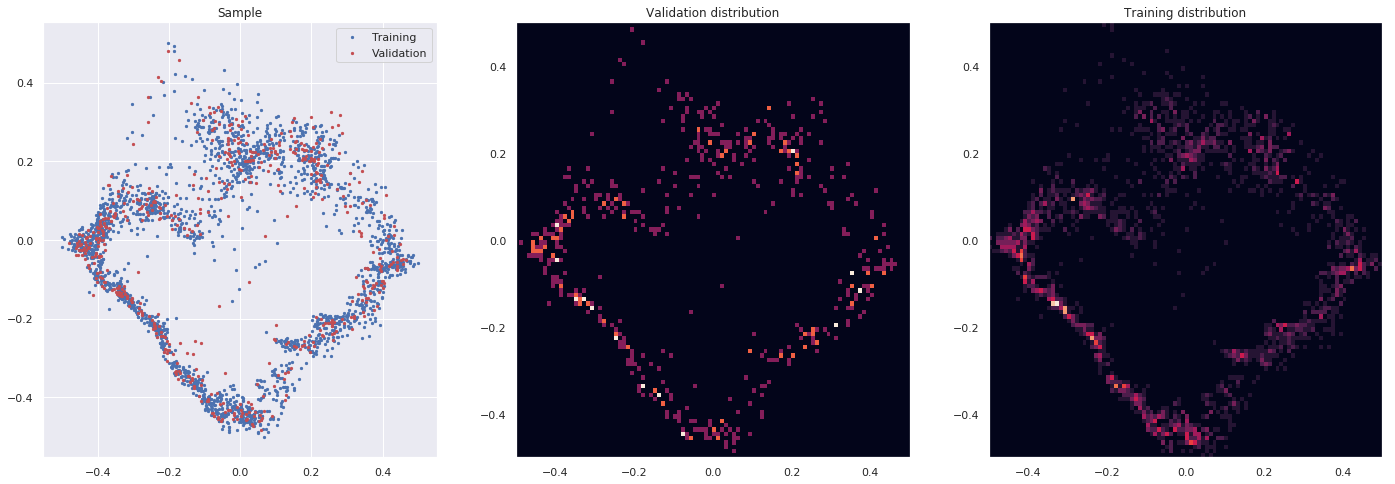

In [20]:
plotDistribution(pca_srl_data, num_val)

In [22]:
pca_srl_data.shape

(2816, 2)

In [56]:
def deleteData(data_folder, del_index=[], srl_model_path=None):
    state_dim = getSRLDim(srl_model_path)
    srl_model = loadSRLModel(srl_model_path, th.cuda.is_available(), state_dim, env_object=None)

    # load images and other data
    print('Loading data for separation ')
    training_data, ground_truth, true_states, _ = loadData(data_folder, absolute_path=True)
    images_path = ground_truth['images_path']
    ground_truth_states_dim = true_states.shape[1]
    # we change the path to the local path at the toolbox level
    images_path_copy = ["srl_zoo/data/" + images_path[k] for k in range(images_path.shape[0])]
    images_path = np.array(images_path_copy)
    
    ground_truth_load = np.load(os.path.join(data_folder, "/ground_truth.npz"))
    preprocessed_load = np.load(os.path.join(data_folder, "/preprocessed_data.npz"))
    
    

In [36]:
data_index.shape, pca_srl_data.shape

((19456,), (19456, 2))

In [43]:
from functools import partial
def _del_val(p_val,train_set, threshold):
    for p_train in train_set:
        if(1.e-10<np.linalg.norm(p_val-p_train) < threshold):
            # we will delete the data point
            return True
    return False

In [76]:
multiprocessing.cpu_count()-1

15

In [ ]:
threshold = 0.003
test_set = pca_srl_data
pool = Pool(multiprocessing.cpu_count()-1)
%time index_del = pool.map(partial(_del_val, train_set=test_set, threshold=threshold), test_set)
index_save = [i for i in range(len(index_del)) if not index_del[i]]

In [69]:
index_save.__len__()

4024

In [70]:
test_set[index_save].__len__()

4024

In [71]:
test_set.shape, len(index_del)

((19456, 2), 19456)

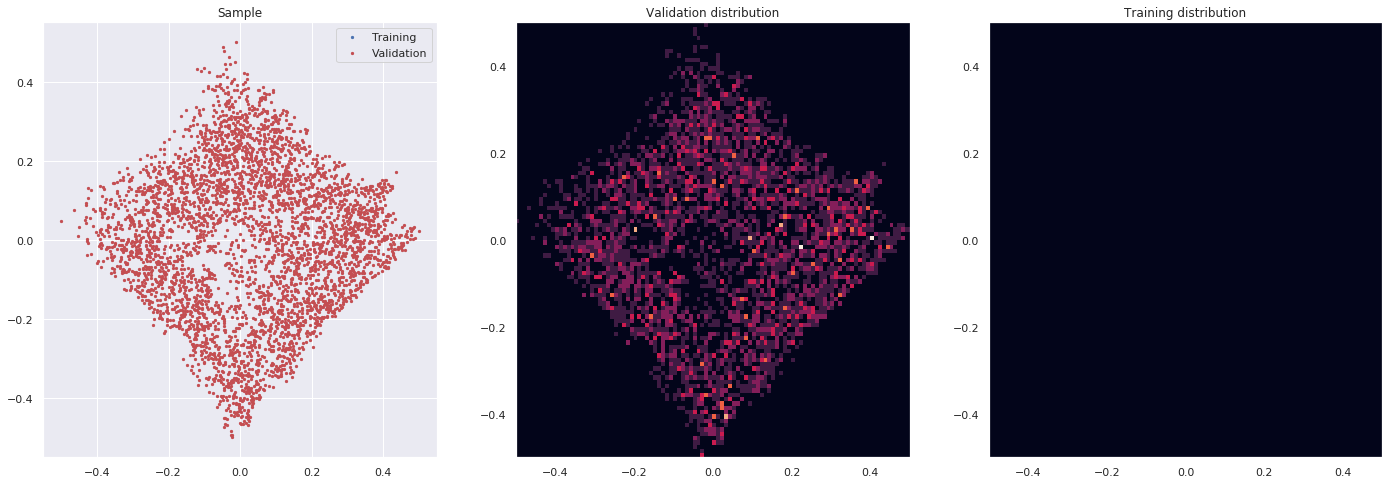

In [72]:
plotDistribution(test_set[index_save], 10000000)

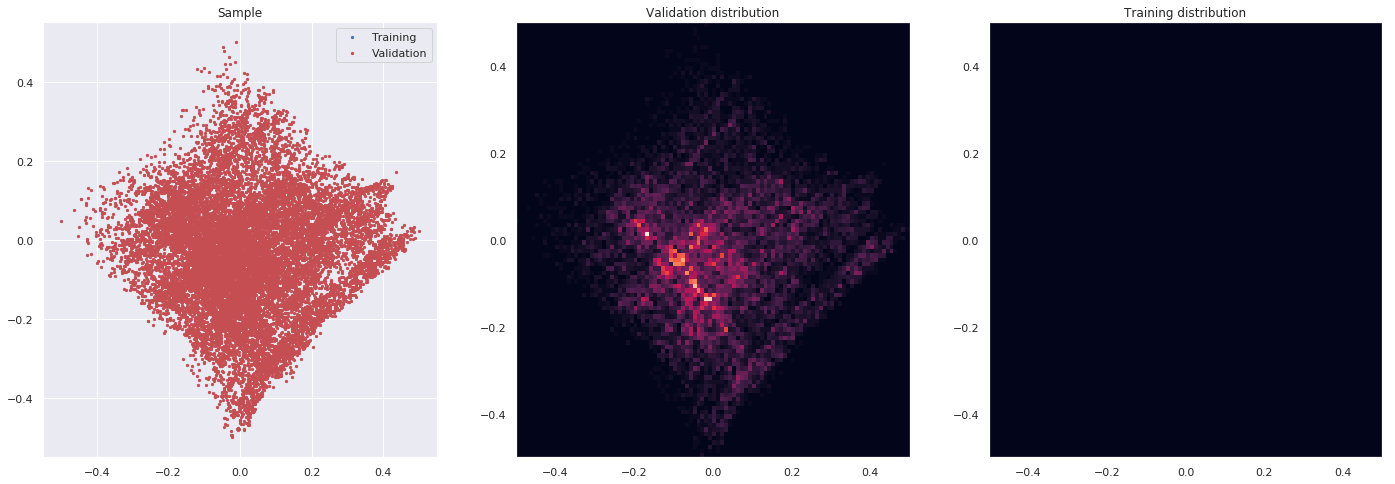

In [73]:
plotDistribution(test_set, 10000000)

In [78]:
pca_srl_data.shape

(19456, 2)

In [87]:
k = np.zeros(12).astype(bool)

In [88]:
k

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [82]:
a =0.0
print(bool(a))
if a:
    print(1)

False


In [147]:
def index_save(data_set, threshold):
    pbar = tqdm(total = len(data_set))
    deleted = np.zeros(len(data_set)).astype(bool)
    for t, test_point in enumerate(data_set):
        pbar.update(1)
        for k, data_point in enumerate(data_set):
            if(not deleted[k] and 1.e-5<np.linalg.norm(test_point-data_point)<threshold):
                deleted[t] = True
    index = [i for i in range(len(deleted)) if not deleted[i]]
    del_index = [i for i in range(len(deleted)) if deleted[i]]
    return deleted, index, del_index
    

In [148]:
data_set = train_set[:10000]

In [149]:
plotDistribution(data_set, 10000000)

In [ ]:
delete, left_index,del_index = index_save(data_set,0.003)

In [ ]:
data_set.shape

In [139]:
left_index.__len__()

6073

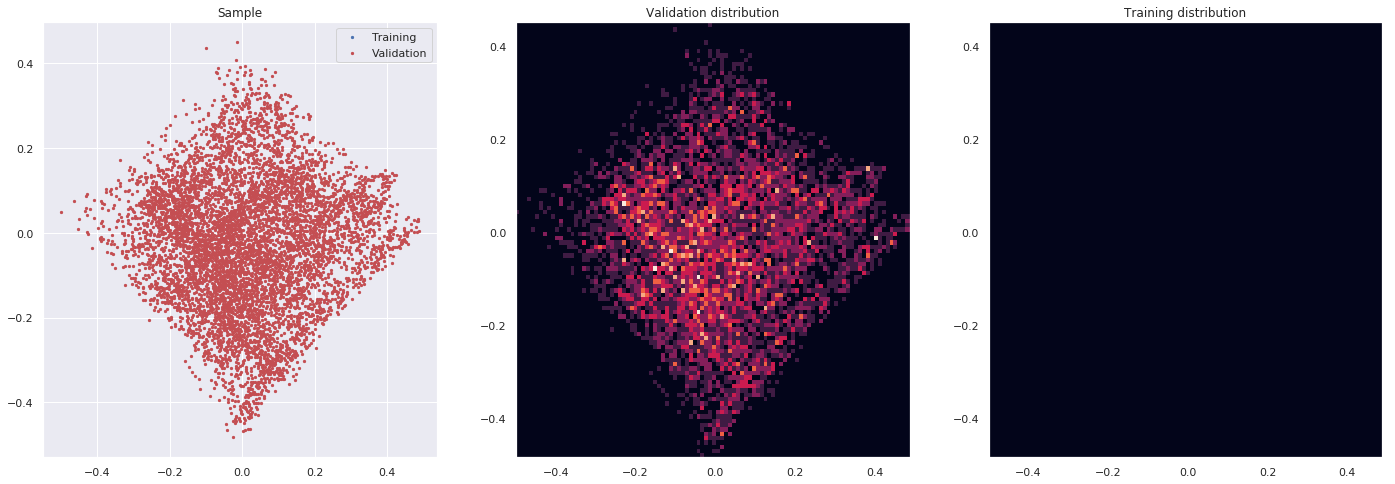

In [140]:
plotDistribution(data_set[left_index], 10000000)

In [141]:
delete


array([False, False, False, ..., False, False, False])

In [142]:
data_set = data_set.copy()

In [ ]:
for i, data in enumerate(data_set):
    np.delete